## $I. Load Dataset:$

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from pandas import Grouper
from pandas import concat
from pandas import DataFrame

In [ ]:
df_VSN = pd.read_csv("/content/gdrive/MyDrive/L/Data/df_VSN.csv")
df_FBA = pd.read_csv("/content/gdrive/MyDrive/L/Data/df_FBA.csv")
df_SGC = pd.read_csv("/content/gdrive/MyDrive/L/Data/df_SGC.csv")
df_BVN = pd.read_csv("/content/gdrive/MyDrive/L/Data/df_BVN.csv")
df_TET = pd.read_csv("/content/gdrive/MyDrive/L/Data/df_TET.csv")  

## $II. Visualization:$ 

In this report, we decided to analyze data by years: 

In [ ]:
#Add col "Year" into dataframes: 
lst_df = [df_VSN, df_FBA, df_SGC, df_TET, df_BVN]
for i in lst_df: 
  i.snapshot_date = i.snapshot_date.apply(lambda x: pd.to_datetime(x))
  i['year'] = i['snapshot_date'].dt.year

In [ ]:
#Get unique years: 
lst = set(df_VSN['year'].values)
lst

{2017, 2018, 2019, 2020, 2021}

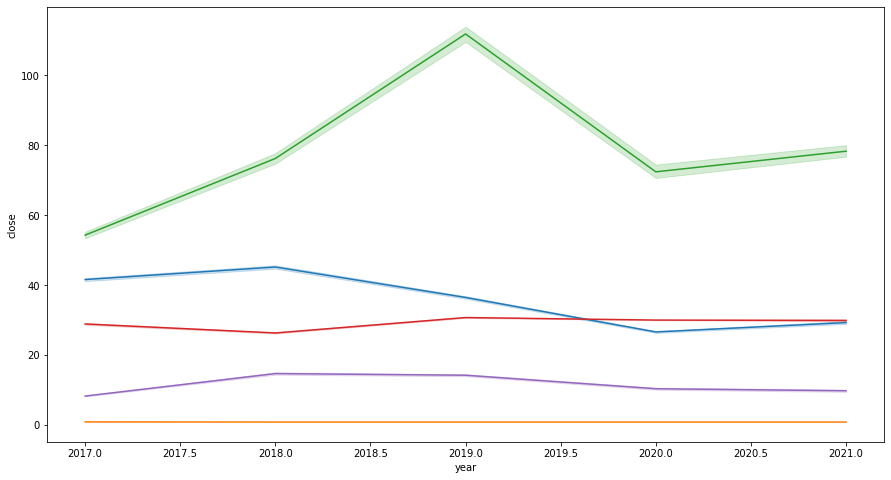

In [ ]:
#Price lineplot for 5 codes: 
plt.figure(figsize=(15,8))
for i in lst_df: 
  sns.lineplot(data = i, x = 'year', y = 'close')
plt.show()

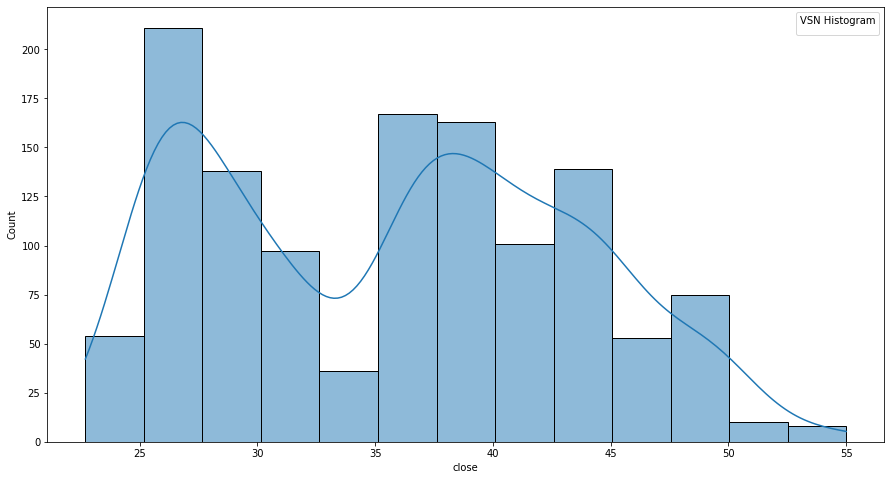

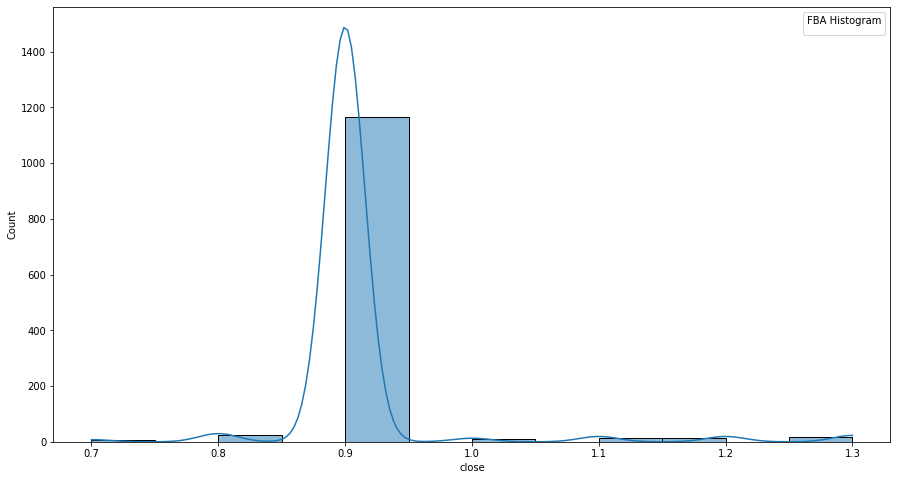

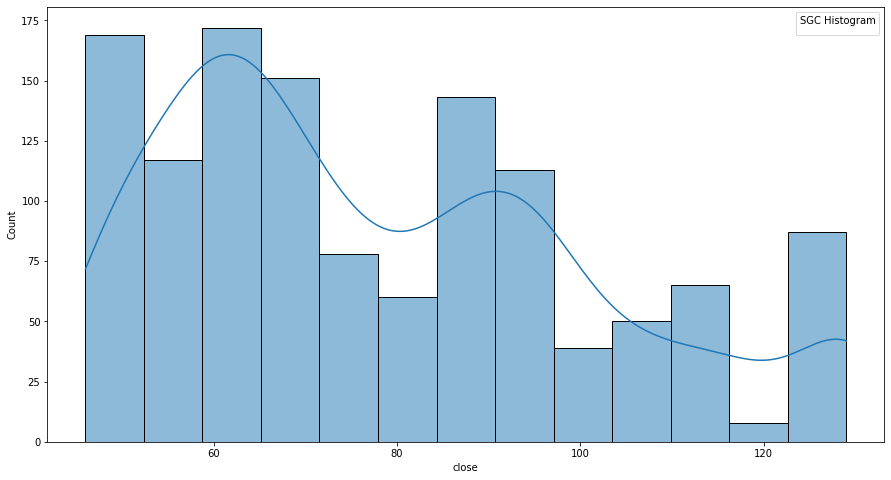

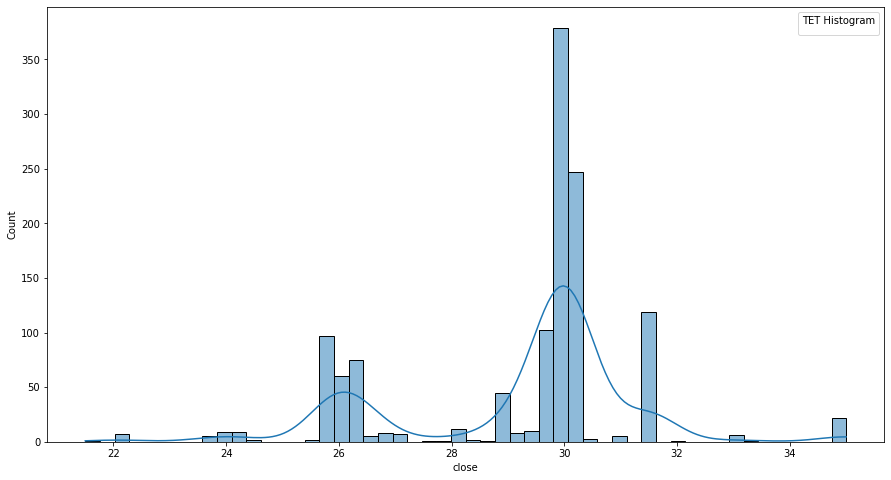

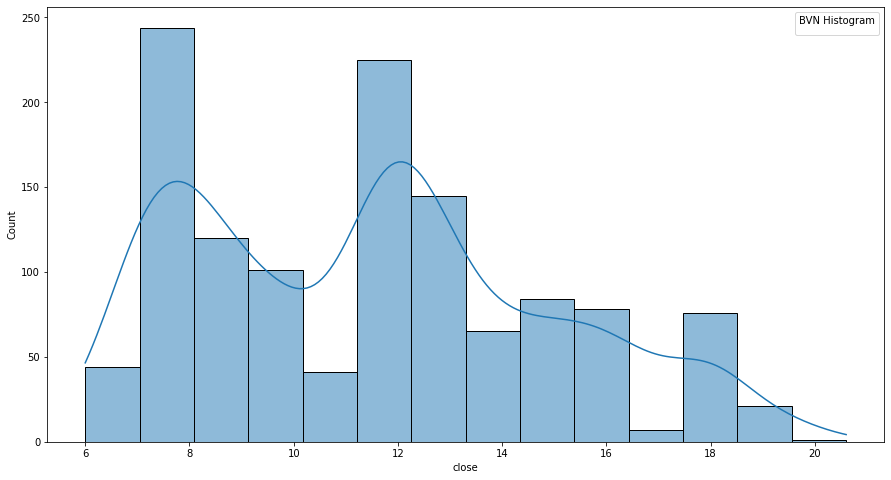

In [ ]:
#Distribution plot for 5 codes: 
for i in lst_df: 
  plt.figure(figsize=(15,8))
  sns.histplot(data = i, x = 'close', kde = True)
  plt.legend(title = i['code'][1] + " Histogram")
  plt.show()

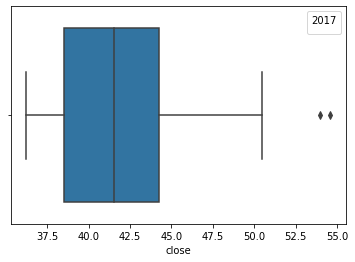

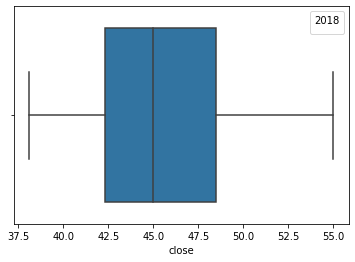

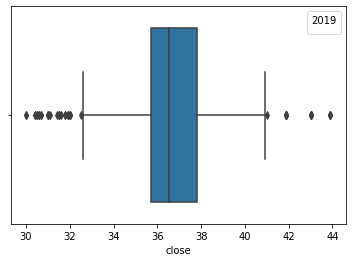

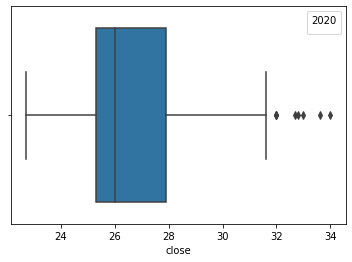

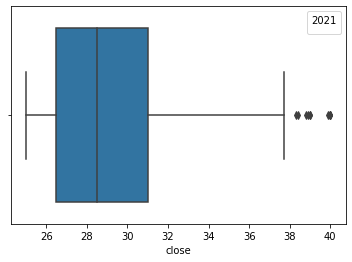

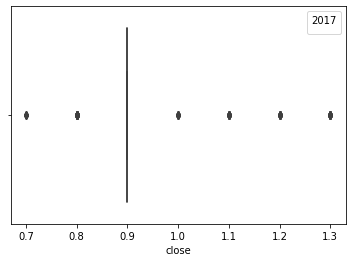

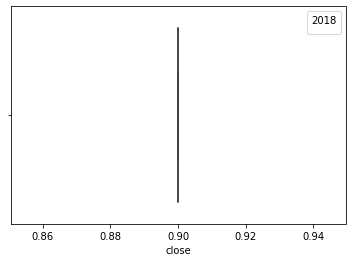

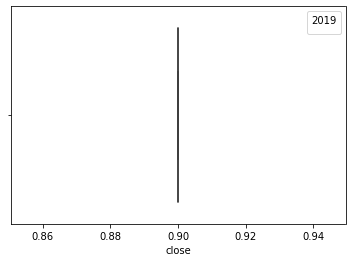

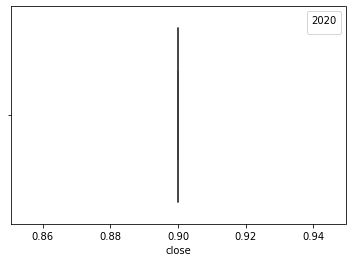

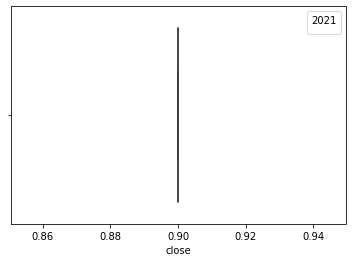

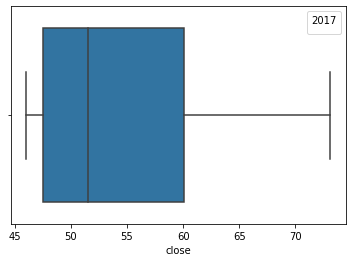

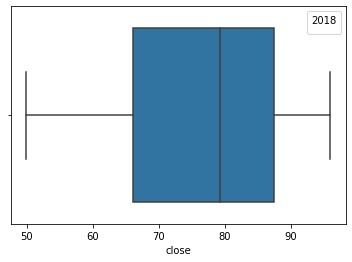

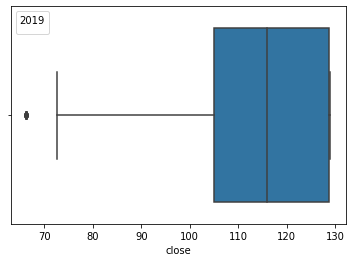

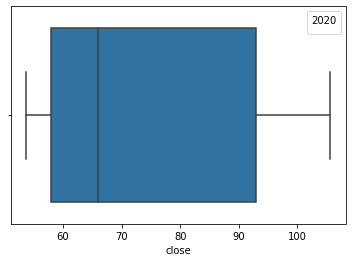

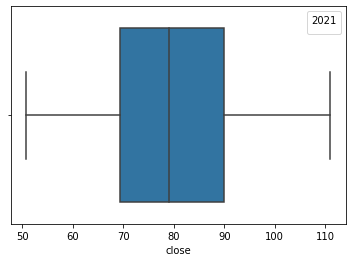

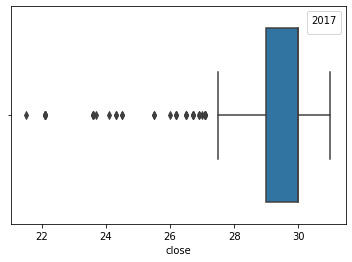

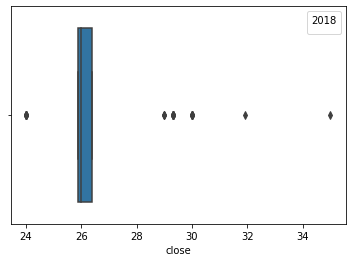

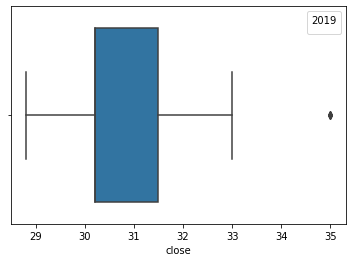

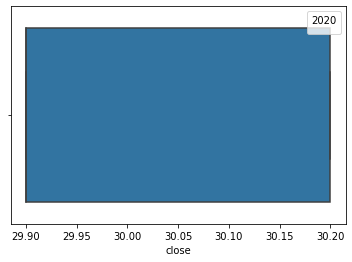

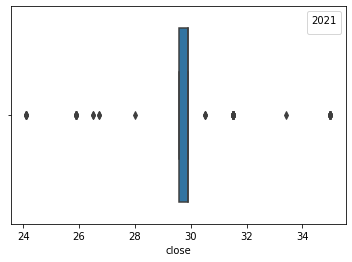

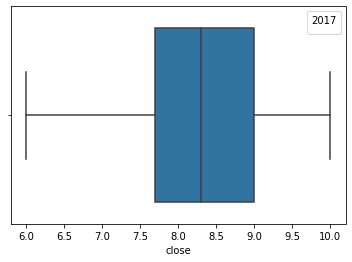

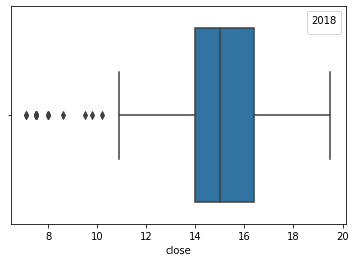

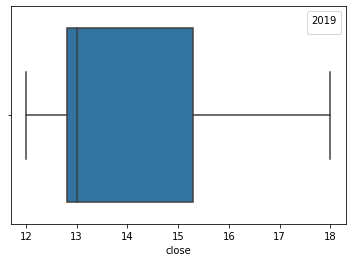

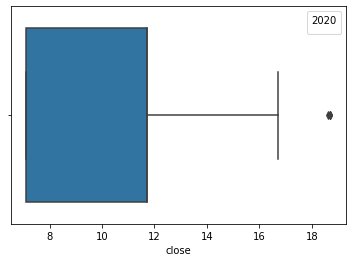

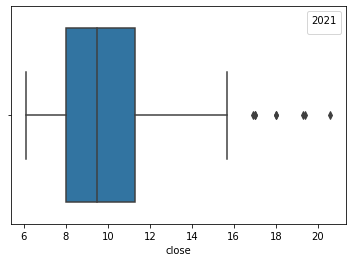

In [ ]:
#Box plot for year: 
for j in lst_df:  
  for i in lst: 
    df = j[j['year'] == i]
    sns.boxplot(data = df, x = df['close'])
    plt.legend(title = i)
    plt.show()

## $III. ACF and PACF plot:$

<Figure size 1080x576 with 0 Axes>

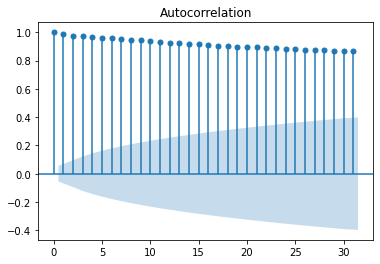

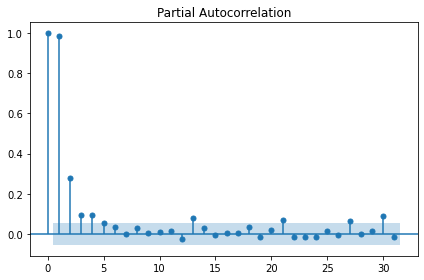

<Figure size 1080x576 with 0 Axes>

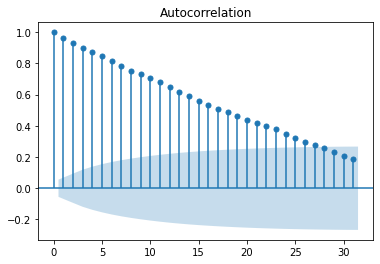

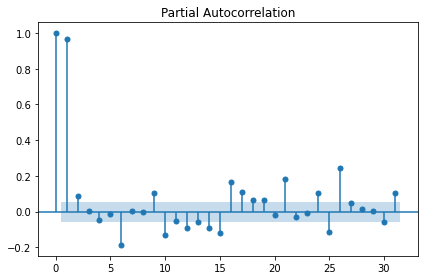

<Figure size 1080x576 with 0 Axes>

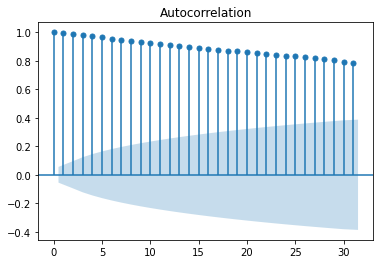

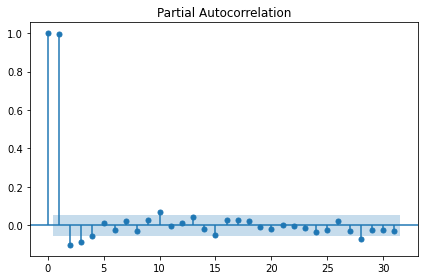

<Figure size 1080x576 with 0 Axes>

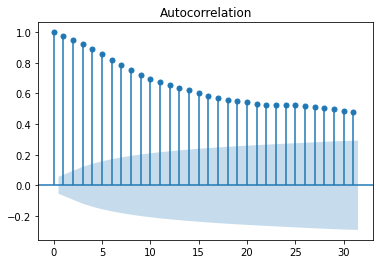

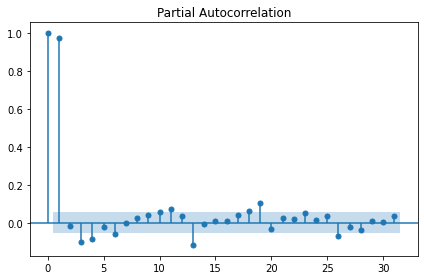

<Figure size 1080x576 with 0 Axes>

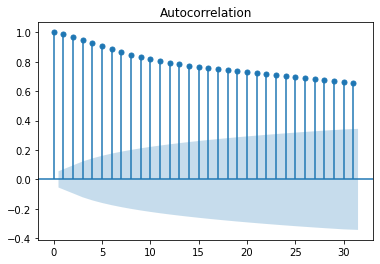

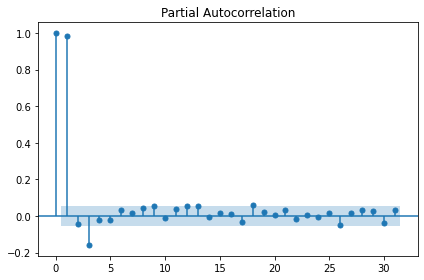

In [ ]:
#ACF and PACF plot for 5 codes: 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

def acf_pacf(sample): 
  plt.figure(figsize = (15,8))
  plot_acf(sample['close'])
  plot_pacf(sample['close'], method='ols')
  plt.tight_layout()
  plt.show()
for df in lst_df:  
   acf_pacf(df)

## $IV. Stationary, seasonality, trend and residual:$

Here we use adfuller statistical test to check whether a series is stationary or not ( P-value > 0.05: Non-stationary, P-value < 0.05: Stationary)

In [ ]:
#Check Stationary for each code:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(df):
    result = adfuller(df.close)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
for df in lst_df:
  check_stationarity(df)

ADF Statistic: -1.989259
p-value: 0.291302
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Non-stationary
ADF Statistic: -7.309367
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary
ADF Statistic: -2.192803
p-value: 0.208868
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Non-stationary
ADF Statistic: -3.293584
p-value: 0.015168
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary
ADF Statistic: -3.719713
p-value: 0.003844
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary


EMA is a very popular indicator to show a price trend. Therefore, we decided to take this technical method first, specifically the EMA 200 for this report. 

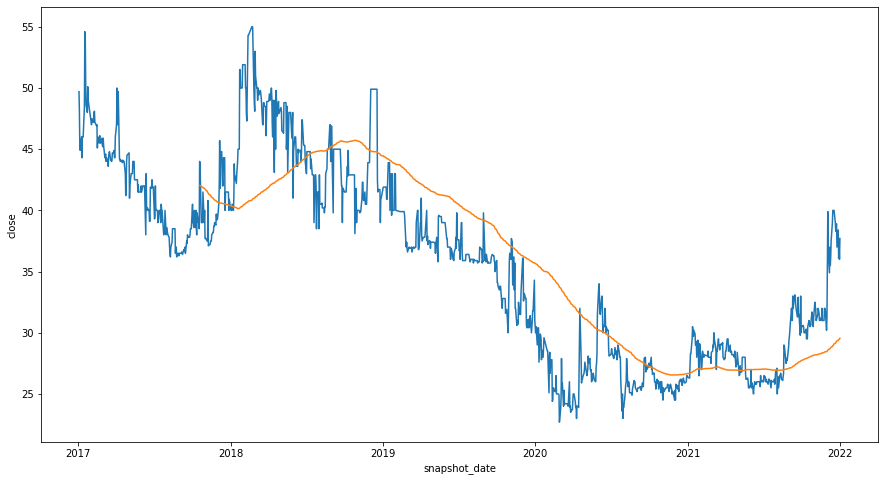

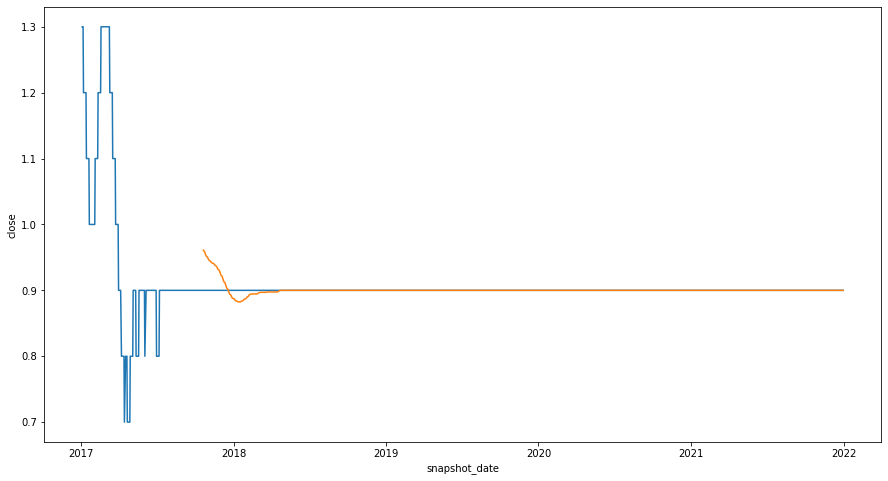

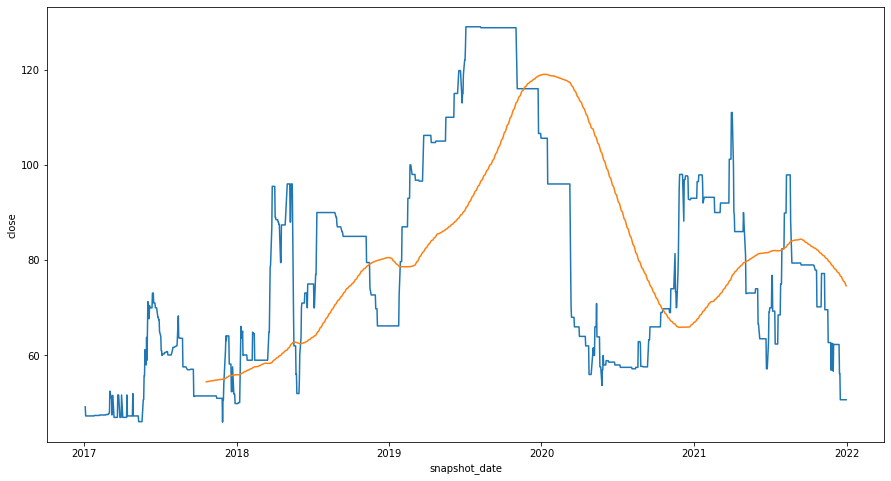

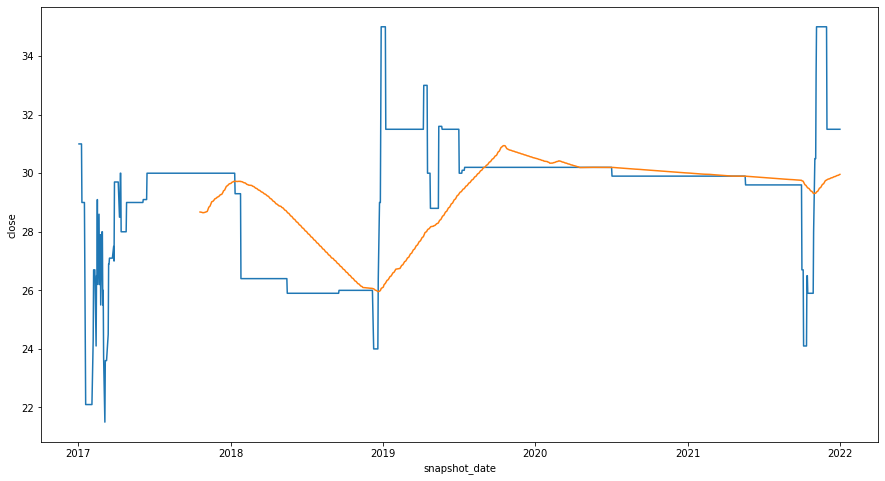

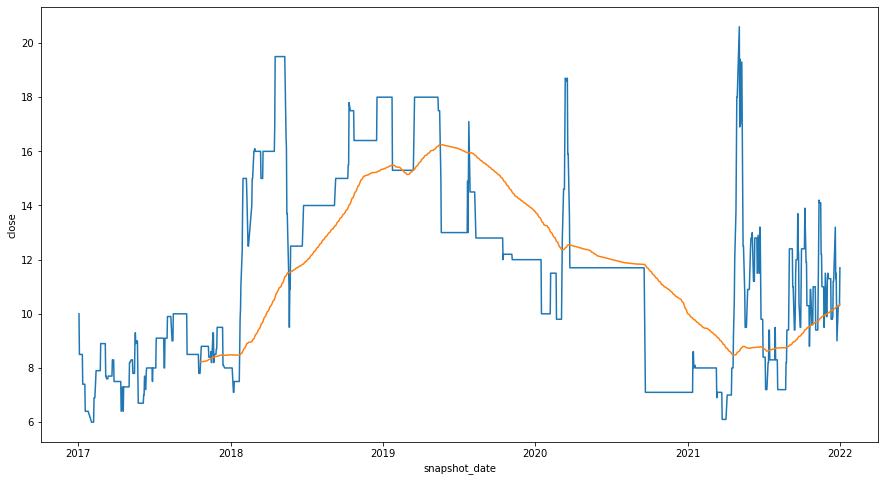

In [ ]:
#MA: 

def moving_average(df, window):
  df['MA']  = pd.DataFrame(df['close'].rolling(window=window).mean())
  return df
for i in lst_df: 
  i = moving_average(i, 200) #Using EMA 200
  plt.figure(figsize = (15,8))
  sns.lineplot(data = i, x = 'snapshot_date', y = 'close')
  sns.lineplot(data = i, x = 'snapshot_date', y = 'MA')
  plt.show()

In [ ]:
df_VSN_new = pd.read_csv("/content/gdrive/MyDrive/L/Data/df_VSN.csv")
df_FBA_new = pd.read_csv("/content/gdrive/MyDrive/L/Data/df_FBA.csv")
df_SGC_new = pd.read_csv("/content/gdrive/MyDrive/L/Data/df_SGC.csv")
df_BVN_new = pd.read_csv("/content/gdrive/MyDrive/L/Data/df_BVN.csv")
df_TET_new = pd.read_csv("/content/gdrive/MyDrive/L/Data/df_TET.csv")  
lst_new = [df_VSN_new,df_FBA_new,df_SGC_new,df_BVN_new,df_TET_new]
for i in lst_new: 
  i.snapshot_date = i.snapshot_date.apply(lambda x: pd.to_datetime(x))
  i = i.set_index('snapshot_date')

Usually, period = 12 (with month interval) or 30 (day interval) will be chooose to show monthly trend, seasonality through years. However with this dataset, we will take period = 30, which makes indexes become less fluactuate.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
def tsindex(df):
  decompose_result_mult = seasonal_decompose(df['close'], period = 30)
  trend = decompose_result_mult.trend
  seasonal = decompose_result_mult.seasonal
  residual = decompose_result_mult.resid
  decompose_result_mult.plot()
  plt.show()

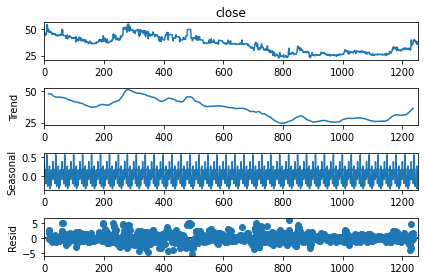

In [ ]:
tsindex(df_VSN_new) #Trend, Seasonal and Residual for V SN:

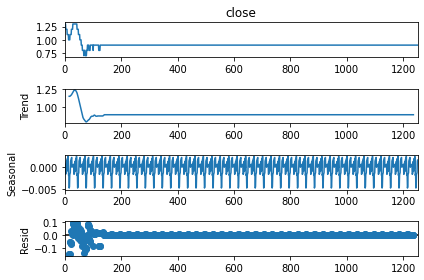

In [ ]:
tsindex(df_FBA_new) #Trend, Seasonal and Residual for FBA:

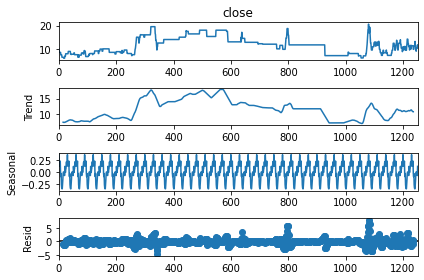

In [ ]:
tsindex(df_BVN_new) #Trend, Seasonal and Residual for BVN:

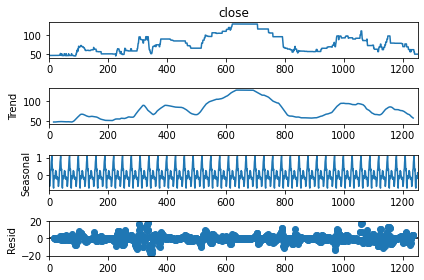

In [ ]:
tsindex(df_SGC_new) #Trend, Seasonal and Residual for SGC:

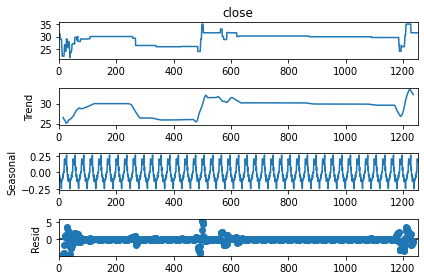

In [ ]:
tsindex(df_TET_new) #Trend, Seasonal and Residual for TET: